<a href="https://colab.research.google.com/github/k-washi/GoogleColab_ML/blob/master/transfer_learnin_vgg_001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# パッケージのimport
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

In [0]:
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

#　GPUを使用して、計算結果を再現する場合は、以下も必要

In [0]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [84]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
ipath = 'drive/My Drive/data/hymenoptera_data/'

In [0]:
class ImageTransform():
  def __init__(self, resize, mean, std):
    self.data_transform = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(
            resize, scale=(0.5, 1.0)),
            transforms.RandomHorizontalFlip(),  # データオーギュメンテーション
            transforms.ToTensor(),  # テンソルに変換
            transforms.Normalize(mean, std)  # 標準化
        ]),
        'val': transforms.Compose([
                transforms.Resize(resize),  # リサイズ
                transforms.CenterCrop(resize),  # 画像中央をresize×resizeで切り取り
                transforms.ToTensor(),  # テンソルに変換
                transforms.Normalize(mean, std)  # 標準化
        ])
    }
  def __call__(self, img, phase='train'):
    return self.data_transform[phase](img)

In [0]:
img = Image.open(ipath + 'train/ants/0013035.jpg')

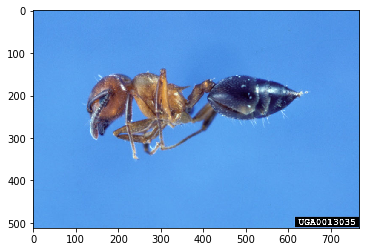

In [88]:
plt.imshow(img)
plt.show()

In [0]:
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

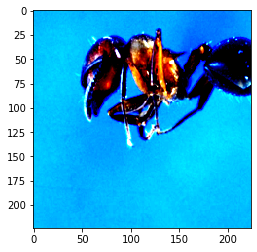

In [90]:
tformer = ImageTransform(size, mean, std)
img_tf = tformer(img, phase='train')

# (色、高さ、幅)を (高さ、幅、色)に変換し、0-1に値を制限して表示
img_tf = img_tf.numpy().transpose((1, 2, 0))
img_tf= np.clip(img_tf, 0, 1)
plt.imshow(img_tf)
plt.show()

In [0]:
#データファイルパスのリストを作成

def make_datapath_list(phase="train"):
  rootpath = ipath
  target_path = osp.join(rootpath + phase + '/**/*.jpg' )
  print(target_path)
  
  path_list = []
  
  for path in glob.glob(target_path):
    path_list.append(path)
   
  return path_list

In [92]:
train_list = make_datapath_list(phase="train")
val_list = make_datapath_list(phase = "val")

print(train_list)

drive/My Drive/data/hymenoptera_data/train/**/*.jpg
drive/My Drive/data/hymenoptera_data/val/**/*.jpg
['drive/My Drive/data/hymenoptera_data/train/bees/2638074627_6b3ae746a0.jpg', 'drive/My Drive/data/hymenoptera_data/train/bees/2861002136_52c7c6f708.jpg', 'drive/My Drive/data/hymenoptera_data/train/bees/507288830_f46e8d4cb2.jpg', 'drive/My Drive/data/hymenoptera_data/train/bees/446296270_d9e8b93ecf.jpg', 'drive/My Drive/data/hymenoptera_data/train/bees/2405441001_b06c36fa72.jpg', 'drive/My Drive/data/hymenoptera_data/train/bees/2962405283_22718d9617.jpg', 'drive/My Drive/data/hymenoptera_data/train/bees/266644509_d30bb16a1b.jpg', 'drive/My Drive/data/hymenoptera_data/train/bees/2470492904_837e97800d.jpg', 'drive/My Drive/data/hymenoptera_data/train/bees/2053200300_8911ef438a.jpg', 'drive/My Drive/data/hymenoptera_data/train/bees/2704348794_eb5d5178c2.jpg', 'drive/My Drive/data/hymenoptera_data/train/bees/1092977343_cb42b38d62.jpg', 'drive/My Drive/data/hymenoptera_data/train/bees/2358

In [0]:
class HymenopteraDataset(data.Dataset):
  def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list  # ファイルパスのリスト
        self.transform = transform  # 前処理クラスのインスタンス
        self.phase = phase  # train or valの指定

  def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)
      
  def __getitem__(self, index):
        '''
        前処理をした画像のTensor形式のデータとラベルを取得
        '''

        # index番目の画像をロード
        img_path = self.file_list[index]
        img = Image.open(img_path)  # [高さ][幅][色RGB]

        # 画像の前処理を実施
        img_transformed = self.transform(
            img, self.phase)  # torch.Size([3, 224, 224])

        # 画像のラベルをファイル名から抜き出す
        """
                if self.phase == "train":
            label = img_path[30:34]
        elif self.phase == "val":
            label = img_path[28:32]
        """


        # ラベルを数値に変更する
        if "ants" in img_path:
            label = 0
        elif  "bees" in img_path:
            label = 1
        else:
          print("Error label{}".format(label))

        return img_transformed, label

In [94]:
# 実行
train_dataset = HymenopteraDataset(
    file_list=train_list, transform=ImageTransform(size, mean, std), phase='train')

val_dataset = HymenopteraDataset(
    file_list=val_list, transform=ImageTransform(size, mean, std), phase='val')

# 動作確認
index = 0
print(train_dataset.__getitem__(index)[0].size()) #Data
print(train_dataset.__getitem__(index)[1]) #Label

torch.Size([3, 224, 224])
1


In [95]:
print(train_dataset)
print(len(train_dataset))
print(len(train_dataset[0]))
print(len(train_dataset[0][0])) #0:data, 1:label
print(len(train_dataset[0][0][0])) #color
print(len(train_dataset[0][0][0][0])) #h
print(train_dataset[0][0][0][0][0]) #w

243
2
3
224
224
tensor(-0.9534)


# Pytorch　DataLoaderの作成

In [0]:
batch_size = 32

# DataLoaderを作成
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)


In [0]:
# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

In [98]:
# 動作確認
batch_iterator = iter(dataloaders_dict["train"])  # イテレータに変換
inputs, labels = next(
    batch_iterator)  # 1番目の要素を取り出す
print(inputs.size())
print(labels)

torch.Size([32, 3, 224, 224])
tensor([0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0,
        1, 0, 1, 1, 1, 1, 1, 0])


In [99]:
# 学習済みのVGG-16モデルをロード
# VGG-16モデルのインスタンスを生成
use_pretrained = True  # 学習済みのパラメータを使用
net = models.vgg16(pretrained=use_pretrained)

# VGG16の最後の出力層の出力ユニットをアリとハチの2つに付け替える
net.classifier[6] = nn.Linear(in_features=4096, out_features=2)

# 訓練モードに設定
net.train()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()

In [101]:
params_to_update = []

# 学習させるパラメータ名
update_param_names = ["classifier.6.weight", "classifier.6.bias"]

# 学習させるパラメータ以外は勾配計算をなくし、変化しないように設定
for name, param in net.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False

# params_to_updateの中身を確認
print("-----------")
print(params_to_update)

classifier.6.weight
classifier.6.bias
-----------
[Parameter containing:
tensor([[ 0.0117,  0.0116,  0.0082,  ..., -0.0072,  0.0059, -0.0065],
        [-0.0071, -0.0131, -0.0117,  ..., -0.0079, -0.0070,  0.0085]],
       requires_grad=True), Parameter containing:
tensor([-0.0087,  0.0008], requires_grad=True)]


In [0]:
# 最適化手法の設定
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)

In [0]:
#モデルの学習関数

def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=10):
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch + 1, num_epochs))
    print('-'*10)
    
    for phase in ['train', 'val']:
      if phase == 'train':
        net.train()
      else:
        net.eval()
      
      e_loss = 0.0
      e_corrects = 0 #正解数
      
      #未学習時の検証用にepoch 0はスキップ
      if epoch == 0 and phase == 'train':
        continue
      
      for inputs, labels in tqdm(dataloaders_dict[phase]):
        optimizer.zero_grad()
        inputs, labels = inputs.cuda(), labels.cuda()
       
        with torch.torch.set_grad_enabled(phase == 'train'):
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          _, preds = torch.max(outputs, 1)

          if phase == 'train':
            loss.backward()
            optimizer.step()
          """
          print()
          print(loss.item())
          print(inputs.size())
          print(torch.sum(preds == labels.data))
          """
          e_loss += loss.item() * inputs.size(0)
          e_corrects += torch.sum(preds == labels.data)      
      
    e_loss = e_loss / float(len(dataloaders_dict[phase].dataset))
    e_acc = e_corrects.double() / len(dataloaders_dict[phase].dataset)

    print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, e_loss, e_acc))
    
      

In [0]:
# 学習・検証を実行する
net = net.cuda()

num_epochs=3
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

In [0]:
print(net)

# Fine Tuning

In [115]:
# VGG-16モデルのインスタンスを生成
use_pretrained = True  # 学習済みのパラメータを使用
net = models.vgg16(pretrained=use_pretrained)

# VGG16の最後の出力層の出力ユニットをアリとハチの2つに付け替える
net.classifier[6] = nn.Linear(in_features=4096, out_features=2)

# 訓練モードに設定
net.train()


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
# ファインチューニングで学習させるパラメータを、変数params_to_updateの1～3に格納する

params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []

# 学習させる層のパラメータ名を指定
update_param_names_1 = ["features"]
update_param_names_2 = ["classifier.0.weight",
                        "classifier.0.bias", "classifier.3.weight", "classifier.3.bias"]
update_param_names_3 = ["classifier.6.weight", "classifier.6.bias"]

# パラメータごとに各リストに格納する
for name, param in net.named_parameters():
    if update_param_names_1[0] in name:
        param.requires_grad = True
        params_to_update_1.append(param)
        print("params_to_update_1に格納：", name)

    elif name in update_param_names_2:
        param.requires_grad = True
        params_to_update_2.append(param)
        print("params_to_update_2に格納：", name)

    elif name in update_param_names_3:
        param.requires_grad = True
        params_to_update_3.append(param)
        print("params_to_update_3に格納：", name)

    else:
        param.requires_grad = False
        print("勾配計算なし。学習しない：", name)

In [0]:

# 最適化手法の設定
optimizer = optim.SGD([
    {'params': params_to_update_1, 'lr': 1e-4},
    {'params': params_to_update_2, 'lr': 5e-4},
    {'params': params_to_update_3, 'lr': 1e-3}
], momentum=0.9)

In [123]:
print(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))

cuda:0


In [0]:
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    # 初期設定
    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)

    # ネットワークをGPUへ
    net.to(device)

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # epochのループ
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの訓練と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
            else:
                net.eval()   # モデルを検証モードに

            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数

            # 未学習時の検証性能を確かめるため、epoch=0の訓練は省略
            if (epoch == 0) and (phase == 'train'):
                continue

            # データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):

                # GPUが使えるならGPUにデータを送る
                inputs = inputs.to(device)
                labels = labels.to(device)

                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)  # 損失を計算
                    _, preds = torch.max(outputs, 1)  # ラベルを予測

                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # 結果の計算
                    epoch_loss += loss.item() * inputs.size(0)  # lossの合計を更新
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率を表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloaders_dict[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

In [0]:
num_epochs=2
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

# 保存・ロード

In [125]:
print(ipath)

drive/My Drive/data/hymenoptera_data/


In [0]:

# PyTorchのネットワークパラメータの保存
save_path = ipath + 'weights_fine_tuning.pth'
torch.save(net.state_dict(), save_path)

In [127]:
load_weights = torch.load(save_path)
net.load_state_dict(load_weights)

# GPU上で保存された重みをCPU上でロードする場合
load_weights = torch.load(save_path, map_location={'cuda:0': 'cpu'})
net.load_state_dict(load_weights)

<All keys matched successfully>